### Setup

In [220]:
%%sh

export PIP_ROOT_USER_ACTION=ignore

pip install -Uq pip
pip install autotrain-advanced==0.6.58
pip install diffusers==0.21.4
pip install autocrop

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### > check version

In [211]:
import torch

print(torch.__version__) # e.g., 2.0.0 at time of post

print(torch.cuda.get_device_name(0)) # e.g., NVIDIA A10G

device_count = torch.cuda.device_count()
assert device_count > 0, "No GPU devices detected."

print("Number of available GPU devices:", device_count)

device = torch.device("cuda")

2.0.1
NVIDIA A10G
Number of available GPU devices: 1


### > Prepare the images. The picture needs to be 1024 x 1024

In [212]:
from tqdm.notebook import tqdm
import os
from pathlib import Path
from itertools import chain
import utils
import shutil

imag_dir=Path("data")
dest_dir = Path("cropped")
dest_dir.mkdir(parents=True, exist_ok=True)

for n,img_path in enumerate(chain(imag_dir.glob("*.[jJ][pP]*[Gg]"),imag_dir.glob("*.[Pp][Nn][Gg]"))):
    try:
        cropped = utils.resize_and_center_crop(img_path.as_posix(), 1024)
        cropped.save(dest_dir / f"image_{n}.png")
    except ValueError:
        print(f"Could not detect face in {img_path}. Skipping.")
        continue

print("Here are the preprocessed images ==========")
[x.as_posix() for x in dest_dir.iterdir() if x.is_file()]

Here are the preprocessed images ==========


['cropped/image_3.png',
 'cropped/image_8.png',
 'cropped/image_1.png',
 'cropped/image_9.png',
 'cropped/image_4.png',
 'cropped/image_5.png',
 'cropped/image_2.png',
 'cropped/image_6.png',
 'cropped/image_7.png',
 'cropped/image_0.png',
 'cropped/image_10.png']

- 8bit adam gobbles the images
- prior-preservation exceeds A10G GPU memory
- xformers gives package error

### > Initialize fine tuning parameters

In [216]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [217]:
# project configuration
project_name = "finetune_jingswu"

model_name_base = "stabilityai/stable-diffusion-xl-base-1.0"
model_name_refiner = "stabilityai/stable-diffusion-xl-refiner-1.0"
model_name_upscaler_4x = "stabilityai/stable-diffusion-x4-upscaler"
model_name_latent_upscaler = "stabilityai/sd-x2-latent-upscaler"

# fine-tuning prompts
# 'oue' is the rare tokens, 'car' is the class
instance_prompt = "photo of <<TOK>>"
class_prompt = "photo of a person"

# fine-tuning hyperparameters
learning_rate = 1e-4
num_steps = 1000
batch_size = 1
gradient_accumulation = 4
resolution = 1024
num_class_image = 50

class_image_path=Path(f"/tmp/priors")

# environment variables for autotrain command
os.environ["PROJECT_NAME"] = project_name
os.environ["MODEL_NAME"] = model_name_base
os.environ["INSTANCE_PROMPT"] = instance_prompt
os.environ["CLASS_PROMPT"] = class_prompt
os.environ["IMAGE_PATH"] = dest_dir.as_posix()
os.environ["LEARNING_RATE"] = str(learning_rate)
os.environ["NUM_STEPS"] = str(num_steps)
os.environ["BATCH_SIZE"] = str(batch_size)
os.environ["GRADIENT_ACCUMULATION"] = str(gradient_accumulation)
os.environ["RESOLUTION"] = str(resolution)
os.environ["CLASS_IMAGE_PATH"] = class_image_path.as_posix()
os.environ["NUM_CLASS_IMAGE"] = str(num_class_image)

### > use autotrain to fine tune

help command will show all the available parameters

```
!autotrain dreambooth --help
```

In [218]:
!autotrain dreambooth \
    --model ${MODEL_NAME} \
    --project-name ${PROJECT_NAME} \
    --image-path "${IMAGE_PATH}" \
    --prompt "${INSTANCE_PROMPT}" \
    --class-prompt "${CLASS_PROMPT}" \
    --resolution ${RESOLUTION} \
    --batch-size ${BATCH_SIZE} \
    --num-steps ${NUM_STEPS} \
    --gradient-accumulation ${GRADIENT_ACCUMULATION} \
    --lr ${LEARNING_RATE} \
    --fp16 \
    --gradient-checkpointing

> INFO    Namespace(version=False, model='stabilityai/stable-diffusion-xl-base-1.0', revision=None, tokenizer=None, image_path='cropped', class_image_path=None, prompt='photo of <<TOK>>', class_prompt='photo of a person', num_class_images=100, class_labels_conditioning=None, prior_preservation=None, prior_loss_weight=1.0, project_name='finetune_jingswu', seed=42, resolution=1024, center_crop=None, train_text_encoder=None, batch_size=1, sample_batch_size=4, epochs=1, num_steps=1000, checkpointing_steps=100000, resume_from_checkpoint=None, gradient_accumulation=4, gradient_checkpointing=True, lr=0.0001, scale_lr=None, scheduler='constant', warmup_steps=0, num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=None, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.01, adam_epsilon=1e-08, max_grad_norm=1.0, allow_tf32=None, prior_generation_precision=None, local_rank=-1, xformers=None, pre_compute_text_embeddings=None, tokenizer_max_length=None, text_encoder_use_attention

### > Load the fine tune model

In [228]:
!pip install -Uq transformers==4.26.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autotrain-advanced 0.6.58 requires transformers==4.36.1, but you have transformers 4.26.0 which is incompatible.


In [229]:
import transformers
transformers.__version__

'4.26.0'

In [230]:
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline

pipeline = DiffusionPipeline.from_pretrained(
    model_name_base,
    torch_dtype=torch.float16,
).to(device)

pipeline.load_lora_weights(
    project_name, 
    weight_name="pytorch_lora_weights.safetensors",
    adapter_name="jingswu"
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
subject_prompt = """photo of <<TOK>>, epic front portrait, with glasses, zoom in, suit and tie, young and handsome, symmetry, blured background, futuristic cityscape"""

subject_negative_prompt = """ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands"""

In [ ]:
import random

seed = random.randint(0, 100000)
generator = torch.Generator(device).manual_seed(seed)
base_image = pipeline(
    prompt=subject_prompt, 
    negative_prompt=subject_negative_prompt,
    num_inference_steps=50,
    generator=generator,
    height=1024,
    width=1024,
    output_type="pil",
).images[0]
base_image

## Load the weights file into model package



In [185]:
import sagemaker
import boto3
import time
import json
from io import BytesIO
import base64
from PIL import Image

from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

s3_prefix = (
    "stable-diffusion-dreambooth-workshop"  # folder within bucket where code artifact will go
)

region = sess._region_name
account_id = sess.account_id()
mme_prefix = f"{s3_prefix}/inference/models"

model_data_url = f"s3://{bucket}/{mme_prefix}/"

In [186]:
model_repo = "model_dir"

model_name = "jingswu"
lora_weights = f"{project_name}/pytorch_lora_weights.safetensors"

dest_dir = f"{model_repo}/{model_name}/1"

shutil.copy(lora_weights, dest_dir)

'model_dir/jingswu/1/pytorch_lora_weights.safetensors'

Create the tar file

In [187]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [188]:
tar_name = f"{model_name}.tar.gz"
!tar -C $model_repo -czvf $tar_name $model_name

sess.upload_data(path=tar_name, bucket=bucket, key_prefix=mme_prefix)
!rm $tar_name

jingswu/
jingswu/config.pbtxt
jingswu/1/
jingswu/1/pytorch_lora_weights.safetensors
jingswu/1/model.py


## Deploy endpoint
Now, you get the customer container url

In [189]:
%store -r extended_triton_image_uri

you are now ready to configure and deploy the multi-model endpoint

In [190]:
sm_client = boto3.client(service_name="sagemaker")

container = {
    "Image": extended_triton_image_uri,
    "ModelDataUrl": model_data_url, #f"{model_data_url}{tar_name}",     # S3 location of the models
#     "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "jingswu"}
    "Mode": "MultiModel",
}

In [191]:
sm_model_name = name_from_base(f"{mme_prefix.split('/')[0]}-models")

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-east-1:376678947624:model/stable-diffusion-dreambooth-workshop-mo-2024-02-19-04-23-07-839


Create a SageMaker endpoint configuration.



In [192]:
endpoint_config_name = name_from_base(f"{mme_prefix.split('/')[0]}-epc")

instance_type = 'ml.g5.2xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:376678947624:endpoint-config/stable-diffusion-dreambooth-workshop-ep-2024-02-19-04-23-09-237


Create the endpoint, and wait for it to transition to InService state. (This takes about 5 mins)

In [193]:
endpoint_name = name_from_base(f"{mme_prefix.split('/')[0]}-ep")

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:376678947624:endpoint/stable-diffusion-dreambooth-workshop-ep-2024-02-19-04-23-11-352
Status: InService


## Invoke the LoRA fine tuned model

In [198]:
sm_runtime = boto3.client("sagemaker-runtime")

In [199]:
# helper functions to encode and decode images
def decode_image(img):
    buff = BytesIO(base64.b64decode(img.encode("utf8")))
    image = Image.open(buff)
    return image

In [208]:
import random

prompt = """photo of <<TOK>>, epic front portrait, with glasses, zoom in, suit and tie, young and handsome, symmetry, blured background, futuristic cityscape"""

negative_prompt = """ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands"""

seed = random.randint(1, 1000000000)
gen_args = json.dumps(dict(num_inference_steps=50, guidance_scale=7, height=1024, width=1024, seed=seed))

inputs = dict(prompt = prompt,
              negative_prompt = negative_prompt,
              gen_args = gen_args)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

CPU times: user 4.28 ms, sys: 533 µs, total: 4.81 ms
Wall time: 17.9 s


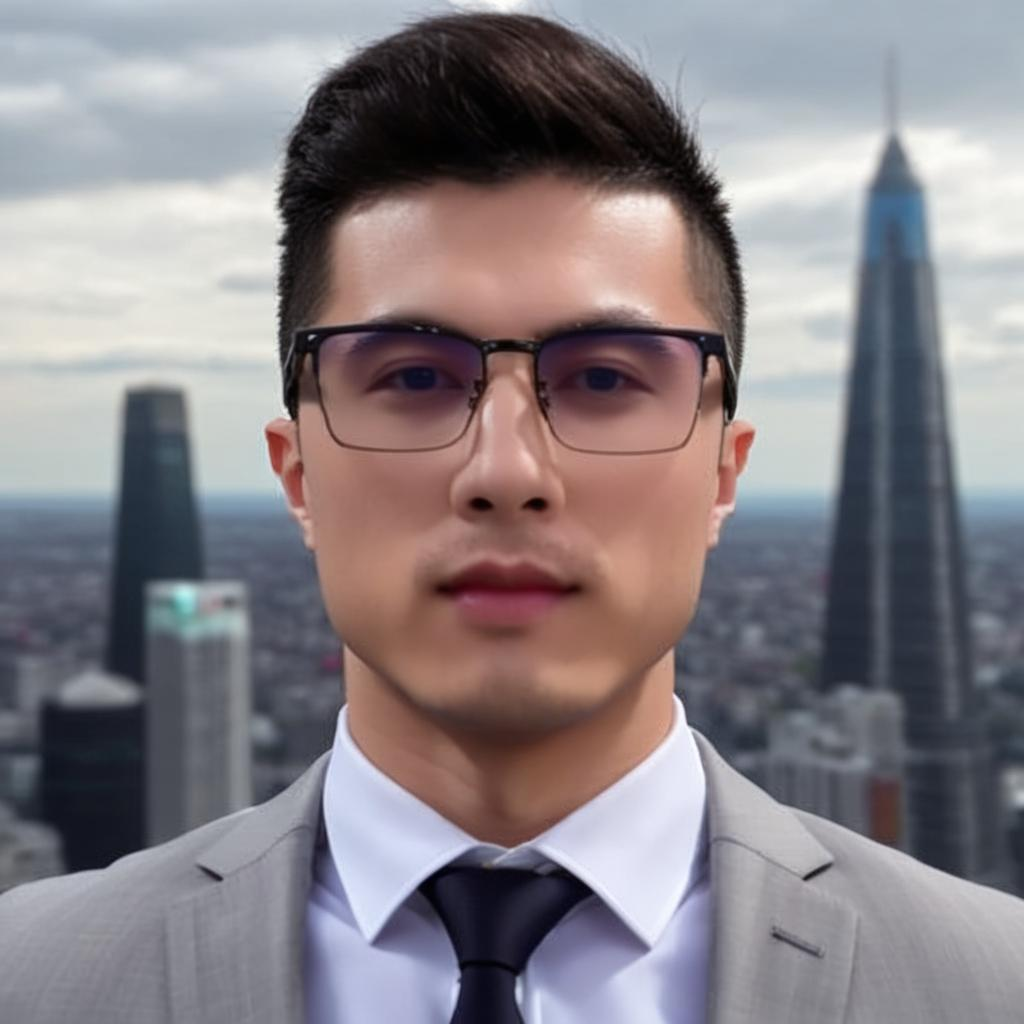

In [209]:
%%time
response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=tar_name,
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
original_image = decode_image(output[0]["data"][0])
original_image

## Clean Up

In [150]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=sm_model_name)

{'ResponseMetadata': {'RequestId': '865789e0-c4bc-4379-bc79-af9c4dbd0457',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '865789e0-c4bc-4379-bc79-af9c4dbd0457',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 19 Feb 2024 01:14:32 GMT'},
  'RetryAttempts': 0}}